# Multi Touch Attribution Models Using Logistic Regression

## Multi Touch Attribution Models

Advertising campaigns are often launched across multiple channels. Traditional advertising channels include outdoor billboard, TV, radio, newspapers and magazines, and direct mailing. Digital advertising channels include search, online display, social, video, mobile and email. Regarding the digital advertising channels, typically, multiple advertising channels have delivered advertisement impressions to a user. When the user then makes a purchase decision or signs up to a service being advertised, the advertiser wants to determine which ads have contributed to the user’s decision. This step is critical in completing the feedback loop so that one can analyze, report and optimize an advertising campaign. This problem of interpreting the influence of advertisements to the user’s decision process is called the attribution problem. The goal of attribute modeling is to pin-point the credit assignment of each positive user to one or more advertising touch point, which is illustrated in Figure 1. (Shao et al., 2011)

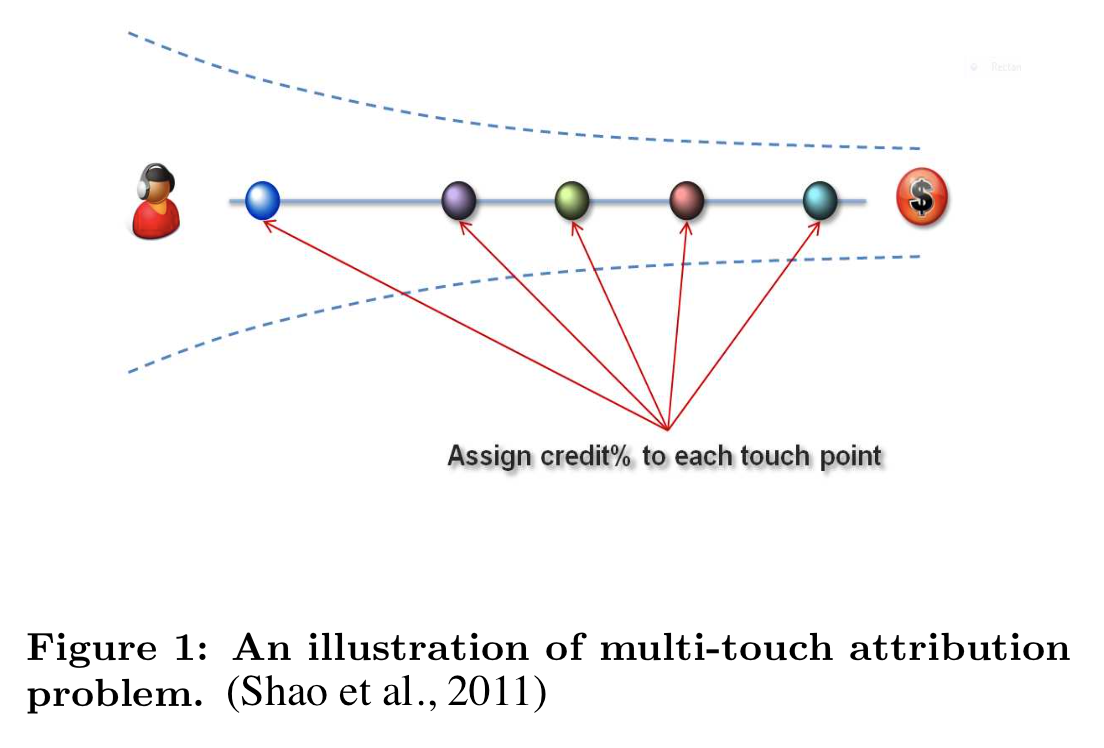

## Problem Settings

- Given: touch points from multiple channels
- Goal: predict binary outcome; positive meaning a user is to make a purchase action and negative meaning otherwise

This is a typical classification problem

## Data

We used the data from Kaggle (https://www.kaggle.com/kishlaya18/customer-purchase-journey-netherlands#TravelData.csv). TravelData.csv is the major file containing information about the customer purchase journey across different online platforms.

## Data Attribute

1. UserID: unique user ID one user may have multiple purchases, so can be connected with more than one PurchaseID
2. PurchaseID: unique purchase ID	unique ID to identify which touchpoint is related to a certain purchase journey
3. TIMESPSS: time stamp including year, month, day, hour, minute and second
4. Duration: seconds spend on a touchpoint (capped at 720 seconds). this information is not available for Company initiated touchpoints
5. DEVICE_TYPE: Indicates whether the touchpoint was reached with a smartphone/tablet (MOBILE) or desktop/laptop (FIXED)
6. type_touch: type of touchpoint (see below)
7. purchase_own: indicates whether a certain purchase journey is related to a booking with the travel agency
8. purchase_any: indicates whether a certain purchase journey is related to a booking with the travel agency or a competitor
9. MobilePanel: months the UserID was part of the mobile panel (max = 17 = all months). this number is user related rather than touchpoint related (similar to demographics)
10. FixedPanel: months the UserID was part of the fixed panel (max = 17 = all months). this number is user related rather than touchpoint related (similar to demographics)

You can download the data via [this link](httpshttps://drive.google.com/file/d/1TLq6txFNfONwjA4ObETsm0vl6q5vY2tm/view?usp=sharing)

### Description regarding 6. type_touch

- 1. Accomodations Website; Consumer initiated touchpoint
- 2. Accomodations App; Consumer initiated touchpoint
- 3. Accomodations Search; Consumer initiated touchpoint
- 4. Information / comparison Website; Consumer initiated touchpoint
- 5. Information / comparison App; Consumer initiated touchpoint
- 6. Information / comparison Search; Consumer initiated touchpoint
- 7. Touroperator / Travel agent Website Competitor; Consumer initiated touchpoint
- 8. Touroperator / Travel agent App Competitor; Consumer initiated touchpoint
- 9. Touroperator / Travel agent Search Competitor; Consumer initiated touchpoint
- 10. Touroperator / Travel agent Website Focus brand; Consumer initiated touchpoint
- 12. Touroperator / Travel agent Search Focus brand; Consumer initiated touchpoint
- 13. Flight tickets Website; Consumer initiated touchpoint
- 14. Flight tickets App; Consumer initiated touchpoint
- 15. Flight tickets Search; Consumer initiated touchpoint
- 16. generic search; Consumer initiated touchpoint
- 18. AFFILIATES; Company intiated touchpoint (Focus brand)
- 19. BANNER; Company intiated touchpoint (Focus brand)
- 20. EMAIL; Company intiated touchpoint (Focus brand)
- 21. PREROLLS; Company intiated touchpoint (Focus brand)
- 22. RETARGETING; Company intiated touchpoint (Focus brand)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt

In [3]:
# Read Wholesale customers data
df = pd.read_csv('TravelData.csv')

# Show dataframe
df.head()

,UserID,PurchaseID,TIMESPSS,Duration,DEVICE_TYPE,type_touch,purchase_own,purchase_any,MobilePanel,FixedPanel
0,9558,1,2016-03-12 22:18:34,5.786,MOBILE,7.0,0.0,0.0,0.0,0.0
1,9558,1,2016-03-13 05:25:49,65.725,MOBILE,7.0,0.0,0.0,0.0,0.0
2,9558,1,2016-03-13 12:26:21,6.492,MOBILE,7.0,0.0,0.0,0.0,0.0
3,9657,2,2015-07-18 13:00:38,57.000,FIXED,4.0,0.0,0.0,0.0,0.0
4,1,3,2015-08-07 19:16:59,120.000,FIXED,7.0,0.0,0.0,0.0,17.0


In [4]:
touch_dict = {1: "Accomodations Website",
              2: "Accomodations App",
              3: "Accomodations Search",
              4: "Comparison Website",
              5: "Comparison App",
              6: "Comparison Search",
              7: "Travel agent Website Competitor",
              8: "Travel agent App Competitor",
              9: "Travel agent Search Competitor",
              10: "Travel agent Website Focus brand",
              12: "Travel agent Search Focus brand",
              13: "Flight tickets Website",
              14: "Flight tickets App",
              15: "Flight tickets Search",
              16: "generic search",
              18: "AFFILIATES",
              19: "BANNER",
              20: "EMAIL",
              21: "PREROLLS",
              22: "RETARGETING"
             }

touch_df = pd.DataFrame(list(touch_dict.items()), columns=['type_touch','touch_name'])
df = pd.merge(df, touch_df, how='left', on='type_touch')

## Preprocessing of data

It is often the case that we need to preprocess the data so that we can run machine learning models as intended. 
In this time, we want to know which touchpoints is influential to purchase decision. Given this datasets, it is natural to see if a customer visited each touchpoint or not can be a starting point.

## Prepare for X: features / independent variables
We first calculate sum of duration by purchase ID and type of touchpoint.

In [5]:
X = df.groupby(['PurchaseID', 'touch_name'])['touch_name'].agg('nunique').unstack().fillna(0)
X.head()

touch_name,AFFILIATES,Accomodations App,Accomodations Search,Accomodations Website,BANNER,Comparison App,Comparison Search,Comparison Website,EMAIL,Flight tickets App,Flight tickets Search,Flight tickets Website,PREROLLS,RETARGETING,Travel agent App Competitor,Travel agent Search Competitor,Travel agent Search Focus brand,Travel agent Website Competitor,Travel agent Website Focus brand,generic search
PurchaseID,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


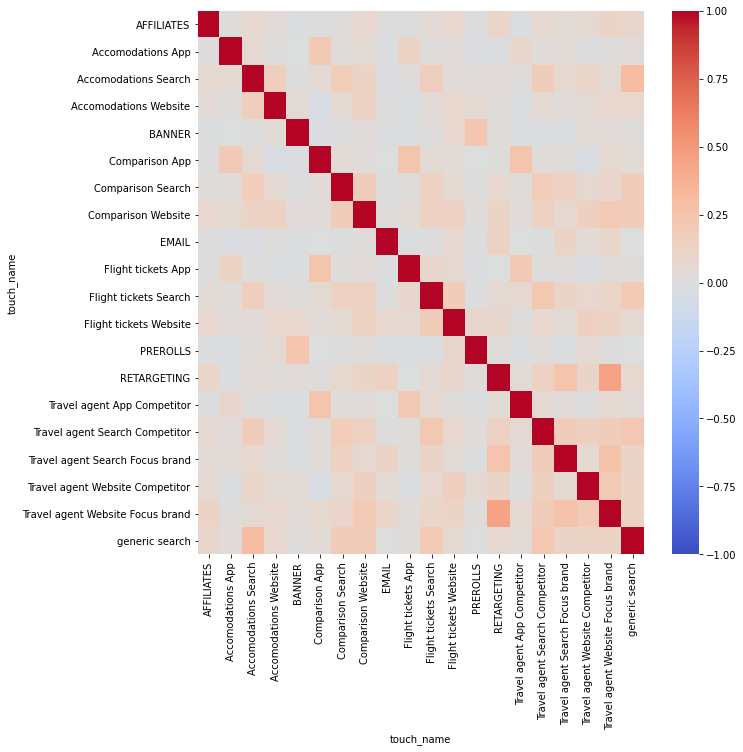

In [6]:
import seaborn as sns
plt.figure(figsize=(10,10))

sns.heatmap(X.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=False);

## Prepare for y: dependent variables

In a real world, data are often not collected in ideal or intended fashion; Specifically, it could be possble that we have such erroneous records as we observe a user made a decision to purchase and decision not to purchase at the same time. This should not be exisiting of course, however, we can possibly observe erroneous records. Is is always a good habit to check if there is erroneous records. Hence, we check the uniqueness of customer decision per purchase ID. 

In [7]:
# Check uniqueness of customer decision (made purchase decision or not) per purchase ID
assert 1 == len(set(df.groupby(['PurchaseID'])['purchase_any'].agg('nunique')))

We did not observe any erroneous records in terms of uniqueness of customer decision per purchase ID. Then, we can move on to dependent variables. Basically, we want to know customer decision was purchase or non-purchase per purchase ID. 

In [8]:
# Given purchase_any should be unique, mean should return 0 or 1
y = df.groupby(['PurchaseID'])['purchase_any'].agg('mean')
y.head()

PurchaseID
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: purchase_any, dtype: float64

## Train_test_split

It is common practice to split data into training data and test data. We want to evaluate the model on data which has not seen before, otherwise the model may be just performing well on "known data". By doing this, we can use `train_test_split` function

The option "stratify" is to keep the distribution of data same across training data and test data.

In [9]:
df_count_purchase = df.groupby(['purchase_any'])['purchase_any'].agg('count')
df_count_purchase

purchase_any
0.0    192136
1.0    101996
Name: purchase_any, dtype: int64

In [10]:
df_count_purchase.div(df_count_purchase.sum())

purchase_any
0.0    0.653231
1.0    0.346769
Name: purchase_any, dtype: float64

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

## Logistic Regression

Logistic regression is one of surpervised learning algorithm used for classification problem. Here, we consider 2-class classification problem; Given $N$ data points and labels as training data, we predict the label of new data (test data). Specifically, we have data points showing wherther combination of touchpoint led to purchase or not. Data points are combination of touchpoint, and labels are whether each user made a purchase or not. Through training, we can obtain prediction model. The prediction model indicates which feature is influential (i.e. which touchpoint is influential in purchase decision.)

The algorithm of logistic regression is summirized as follows;

***
### Logistic Regression algorithm
***
Given: Data points $\mathbf{x_n}; n \in \{1,...,N\}$, $y_n \in \{C_1, C_2\}; n \in \{1,...,N\}$ as corresponding label

Goal: Predict the label $y_i \in \{C_1, C_2\}$ as $C_j$ for new data $\mathbf{x_i}$

$$j = arg max_{j \in \{1,2\}} P(y_i \in C_j|\mathbf{x_i}, w)$$
$$P(y_i \in C_i|\mathbf{x_i}, w) = \sigma(\mathbf{x_i}^T w), \quad \sigma(\mathbf{x_i};w) = \frac{1}{1+e^{-\mathbf{x_i}^T w}}$$

$\sigma(\mathbf{x_i};w)$ is called sigmoid function. (Red line in the diagram below shows the shape of sigmoid function)
***

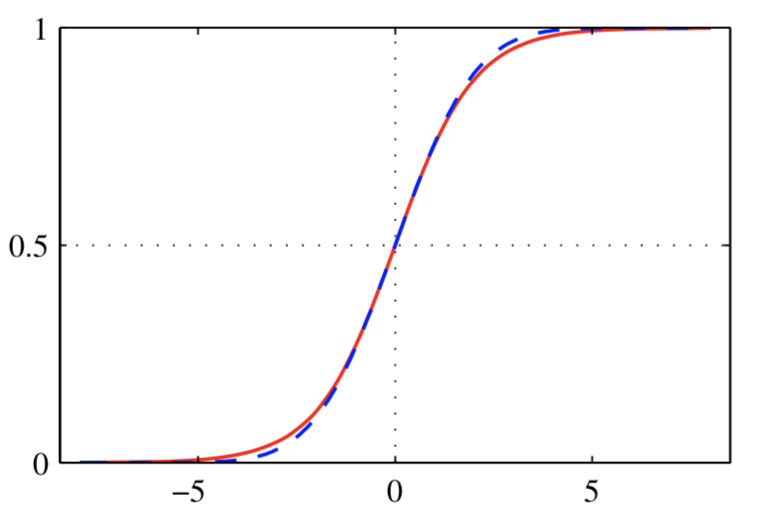

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Influence of each touchpoint

With the model trained, we can estimate which touchpoint is influential in users' decision making. 
Generally speaking, when the magnitude of coefficietns are similar, larger absolute value of coefficient means more influential in prediction. However, if the magnitude of coefficients are different (for example, the case data is not normalized), it does not make sense to compare coefficients. In our case, all feature is about duration (i.e number of seconds), therefore, magnitude is compared across same criteria and coefficients comparison make sense.

In [13]:
print("coefficient = ", lr.coef_)
print("intercept = ", lr.intercept_)

coefficient =  [[ 0.25033588  0.13999028  0.42117539  1.11033057  0.55891793 -0.06811097
   0.41107594  0.45203278  0.04246539 -0.15287728 -0.18429686 -0.03286995
  -0.69035069  0.2741433   0.14803016  0.04231576  0.06696217  0.41583663
   0.64964411  0.37934063]]
intercept =  [-3.63352158]


We see that following touchpoint is most influential and it is positive effect given sign of coefficient is positive.

In [14]:
print("the most influential touchpoint: ", np.argmax(abs(lr.coef_))+1)
print("Its coefficient: ", lr.coef_[0][np.argmax(abs(lr.coef_))])

the most influential touchpoint:  4
Its coefficient:  1.1103305709254303


## Check Prediction Accuracy and Metrics

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
y_pred = lr.predict(X_test)

print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[626   3]
 [ 81   0]]
accuracy =  0.8816901408450705
precision =  0.0
recall =  0.0
f1 score =  0.0


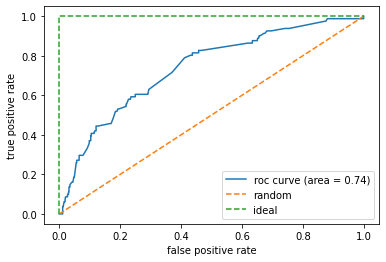

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_score = lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score)

plt.plot(fpr, tpr, label='roc curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

# Bagged Logistic Regression

Bagging (Bootstrap aggregating) was first proposed by Leo Breiman in 1994 to improve classification by combining classifications of randomly generated training sets. One of the most popular bagged approaches is random forest where decision tree models are stacked to increase performance and robustness. The bagging approach possesses the ability to isolate variable collinearity. Shao et al. (2011) used bagged logistic regression to help reduce the estimation variability due to the highly correlated covariates. In this example, bagged logistic regression did not demonstartes better results as there are not much highly correlated covariates as confirmed in the heatmap above.

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

bagging_lr = BaggingClassifier(LogisticRegression(), max_samples=0.5, max_features=0.5)
bagging_lr.fit(X_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='lbfgs', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=0.5,
                  max_samples=0.5, n_estimators=10, n_jobs=None,
                  oob_score=False, random_state=None,

## Check Prediction Accuracy and Metrics

confusion matrix = 
 [[629   0]
 [ 81   0]]
accuracy =  0.8859154929577465
precision =  0.0
recall =  0.0
f1 score =  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


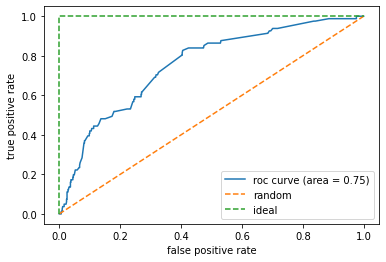

In [18]:
y_pred1 = bagging_lr.predict(X_test)

print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred1))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred1))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred1))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred1))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred1))

y_score1 = bagging_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score1)

plt.plot(fpr, tpr, label='roc curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], linestyle='--', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

## Reference
Shao, X.;Li, L. (2011) Data-driven Multi-touch Attribution Models, KDD’11, August 21–24, 2011, San Diego, California, USA

C,Bishop. (2006), Pattern Recognition and Machine Learning, Springer.